<a href="https://colab.research.google.com/github/ugurtegin/MMF_RNN_Reuse/blob/main/BPM%20Notebooks/GRIN_BPM_Modes_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy.io as sio
import time
from scipy import special

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


absorbing boundary

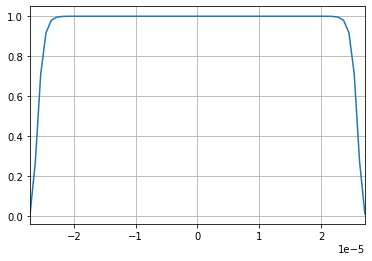

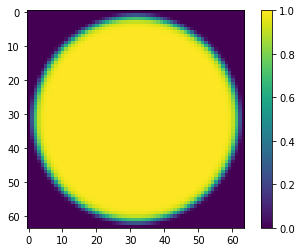

In [23]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=1, sy=1,p=40,w=26.5e-6):
  """define normalized 2D gaussian"""

  return np.exp(-2*((np.sqrt(x**2+y**2)/w)**p))

spacewidth=54.1442e-6

xres=54.1442e-6/64
x = np.linspace(-spacewidth*0.5,spacewidth*0.5,int(spacewidth/xres))

x1, y1 = np.meshgrid(x, x) # get 2D variables instead of 1D
z = gaus2d(x1, y1)

# plt.imshow(z)
# plt.colorbar()

plt.plot(x,z[32,:])
plt.grid()
plt.xlim((-27.072e-6,27.072e-6))
plt.show()

cp_super_gauss2d =cp.asarray(z)
cp_super_gauss2d = cp.repeat(cp_super_gauss2d[:,:,cp.newaxis], 1024, axis=2)

plt.imshow(z)
plt.colorbar()
plt.show()



fiber modes

0.9974434017823995


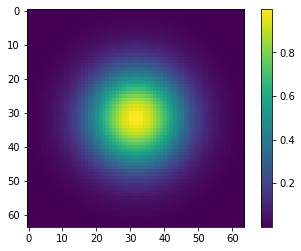

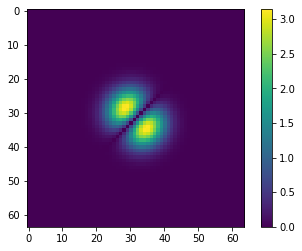

In [24]:
def modes(m,l,fwhm):
  # ref: Arash Mafi, "Bandwidth Improvement in Multimode Optical Fibers Via Scattering From Core Inclusions," J. Lightwave Technol. 28, 1547-1555 (2010)
  # mode numbers:
  p=l-1   # l-1 of LP_ml
  m=m   # m of LP_ml 

  Apm=np.sqrt(np.math.factorial(p)/np.pi/np.math.factorial(p+np.abs(m)))

  c = 299792458               # [m/s]
  n0 = 1.45                   # Refractive index of medium (1.44 for 1550 nm, 1.45 for 1030 nm)
  lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]
  R = 25e-6                   # fiber radius
  w=2*cp.pi*c/lambda_c        # [Hz]
  k0 = w*n0/c
  delta = 0.01                #

  N_2 = 0.5*(R**2)*(k0**2)*(n0**2)*delta
  ro_0= R/(4*N_2)**0.25

  Epm=Apm*(np.sqrt(x1**2+y1**2)**np.abs(m))/(ro_0**(1+np.abs(m)))*np.exp(-(x1**2+y1**2)/2/ro_0**2)*special.eval_genlaguerre(p,np.abs(m),(x1**2+y1**2)/ro_0**2,out=None)

  Epm_=np.multiply(Epm,(np.cos(m*np.arctan2(y1,x1))+np.sin(m*np.arctan2(y1,x1))))
  phase_mod=np.abs(Epm_/np.max(np.abs(Epm_)))*np.pi
  gaussian_mag=np.exp( - (((x1**2)/(2*(fwhm/2.35482)**2)+ (y1**2)/(2*(fwhm/2.35482)**2))))
  return cp.asarray(gaussian_mag*np.exp(1j*phase_mod))
  #return cp.asarray(Epm_/np.max(np.abs(Epm_))) #cp_super_gauss2d =cp.asarray(z)
  #cp_Epm=cp.asarray(Epm_/np.max(np.abs(Epm_)))
  #return 


FF=modes(1,1,20e-6)
print(cp.max(cp.abs(FF)))

FFabs=cp.abs(FF)
FFangle=cp.angle(FF)

plt.imshow(FFabs.get())
plt.colorbar()
plt.show()

plt.imshow(FFangle.get())
plt.colorbar()
plt.show()

#FFtresh=(FFabs>0.1)

#plt.imshow(FFtresh.get())
#plt.colorbar()
#plt.show()

#area=cp.sum(FFtresh)
#print(area)


In [25]:
ttt = time.time()
c = 299792458 # [m/s]
n0 = 1.45                   # Refractive index of medium (1.44 for 1550 nm, 1.45 for 1030 nm)
lambda_c = 1030e-9          # Central wavelength of the input pulse in [m]

## TIME SPACE DOMAIN
timewidth = 1.8e-12          # Width of the time window in [s]
tres = timewidth/((2**10))
t = cp.arange(-timewidth*0.5,(timewidth*0.5),tres)
#t = -timewidth*0.5:tres:timewidth*0.5 # Time in [s]
timesteps=len(t)

spacewidth=54.1442e-6
xres = spacewidth/((2**6))
#x = -spacewidth*0.5:xres:spacewidth*0.5 # Time in [s]
x = cp.arange(-spacewidth*0.5,(spacewidth*0.5),xres)
xsteps=len(x)
y = x
[X,Y,T] = cp.meshgrid(x,y,t)

## FOURIER DOMAIN
fs=1/timewidth
freq = c/lambda_c+fs*cp.linspace(-timesteps/2,timesteps/2,num = timesteps)
#freq=c/lambda_c+fs*linspace(-(timesteps-1)/2,(timesteps-1)/2,timesteps) # [Hz]
wave=c/freq # [m]
w=2*cp.pi*c/lambda_c # [Hz]
omegas=2*cp.pi*freq
wt = omegas-w

#kx = 2*pi/xsteps/xres*x;
#kx = 2*pi/xres*x;

#CHECK KX
a = cp.pi/xres  # grid points in "frequency" domain--> {2*pi*(points/mm)}
N = len(x)
zbam = cp.arange(-a,(a-2*a/N)+(2*a/N),2*a/N)
kx = cp.transpose(zbam) # "frequency" domain indexing ky = kx; 
ky = kx
[KX,KY,WT] = cp.meshgrid(kx,ky,wt);

## OPERATORS
k0 = w*n0/c
n2 = 3.2e-20       #Kerr coefficient (m^2/W)
R = 25e-6
beta2 = 24.8e-27
beta3 = 23.3e-42
gamma = (2*cp.pi*n2/(lambda_c))
delta = 0.01
NL1 = -1j*((k0*delta)/(R*R))*((X**2)+(Y**2))

D1 = (0.5*1j/k0)*((-1j*(KX))**2+(-1j*(KY))**2)
D2 = ((-0.5*1j*beta2)*(-1j*(WT))**2)+((beta3/6)*(-1j*(WT))**3)
D = D1 + D2
s_imgper = (cp.pi*R)/cp.sqrt(2*delta)
dz = s_imgper/48
DFR = cp.exp(D*dz/2)

## INPUT 
flength = s_imgper*10
fstep = flength/dz
x_fwhm = 1
#x_fwhm=cp.linspace(22e-6, 24e-6, num=32) # 20 24, 20 23,,,  22fix 
#x_fwhm_small = 18e-6
#x_fwhm_small=cp.linspace(8e-6, 18e-6, num=1000)  # 12 16, 15 18,,, 5 to 15   8to18
p_don=20
t_fwhm = 100e-15
Ppeak = 1e9 #270*50e3 # W 180
#Ppeak = cp.linspace(3e6, 30e6, num=1000)
data_s=np.zeros((480,64,64))
data_t=np.zeros((480,1024))
fwhm=20e-6

#for musti in range(1000):
#for ulas in range(1):
for ulas2 in range(1000):
  #A = cp.sqrt(Ppeak/(cp.pi*(x_fwhm**2-x_fwhm_small[ulas2]**2)))*cp.exp( - (((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2))**p_don + (T**2)/(2*(t_fwhm/2.35482)**2)))-cp.sqrt(Ppeak/(cp.pi*(x_fwhm**2-x_fwhm_small[ulas2]**2)))*cp.exp( - (((X**2)/(2*(x_fwhm_small[ulas2]/2.35482)**2)+ (Y**2)/(2*(x_fwhm_small[ulas2]/2.35482)**2))**p_don + (T**2)/(2*(t_fwhm/2.35482)**2)));
  #A = cp.sqrt(Ppeak/(cp.pi*(x_fwhm**2)))*cp.exp( - (((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2))**p_don + (T**2)/(2*(t_fwhm/2.35482)**2)))-cp.sqrt(Ppeak/(cp.pi*(x_fwhm**2)))*cp.exp( - (((X**2)/(2*(x_fwhm_small[ulas2]/2.35482)**2)+ (Y**2)/(2*(x_fwhm_small[ulas2]/2.35482)**2))**p_don + (T**2)/(2*(t_fwhm/2.35482)**2)));
  coefs=np.random.rand(6)
  coefs=coefs/np.sum(coefs)
  A_transverse=cp.abs(modes(0,1,fwhm))*cp.exp(1j*(cp.angle(modes(0,2,fwhm))*coefs[1]+cp.angle(modes(0,3,fwhm))*coefs[2]+cp.angle(modes(1,1,fwhm))*coefs[3]+cp.angle(modes(1,2,fwhm))*coefs[4]+cp.angle(modes(2,1,fwhm))*coefs[5]+cp.angle(modes(0,1,fwhm))*coefs[0] ))
  #A_tresh=(A_transverse>0.1)
  #area=cp.sum(FFtresh)*xres**2
  pulse_time=cp.exp(-(T**2)/(2*(t_fwhm/2.35482)**2))
  A=( pulse_time.transpose() * A_transverse.transpose() ).transpose()
  A_tr_max =cp.max(cp.squeeze(cp.sum(cp.square(cp.abs(A)),axis=2)))
  #print(A_tr_max)
  A=A/cp.sqrt(A_tr_max)*cp.sqrt(Ppeak/(cp.pi*(fwhm**2)))
  #A=cp.sqrt(Ppeak/area)*cp.exp( - (((X**2)/(2*(x_fwhm/2.35482)**2)+ (Y**2)/(2*(x_fwhm/2.35482)**2))**p_don*cp.repeat(A_transverse[:,:,cp.newaxis], 1024, axis=2) + (T**2)/(2*(t_fwhm/2.35482)**2)))
  ### MAIN FUNCTION
  Ain = A
  #Asave = cp.zeros((sampesize,64,64,1024), dtype=complex)


  for ugur in range(int(fstep)):
      #print((ugur*dz)+dz)
      Einf=cp.fft.fftshift(cp.fft.fftn(Ain));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      Eout = Ein2;
      
      NL2 = 1j*gamma*cp.abs(Eout)**2;
      NL = NL1+NL2;
      Eout = Eout*cp.exp(NL*dz);
      
      Einf=cp.fft.fftshift(cp.fft.fftn(Eout));
      Ein2=cp.fft.ifftn(cp.fft.ifftshift(Einf*DFR));
      Ain =cp.multiply(cp_super_gauss2d,Ein2);
      Ain_cpu=Ain

      Ain_cpu=cp.square(cp.abs(Ain_cpu))

      ss =cp.squeeze(cp.sum(Ain_cpu,axis=2))
      tt =cp.sum(cp.squeeze(cp.sum(Ain_cpu,axis=0)),axis=0)

      data_s[ugur,:,:]=ss.get()

      data_t[ugur,:]=tt.get()

  sio.savemat('/content/drive/MyDrive/NatMI_MMFwRNN/Data/Phase_9April/data_s'+str(ulas2+1)+'.mat', {'data_s':data_s})
  

A_dis=A.get()
A_disp=np.squeeze(np.sum(A_dis,axis=2))

elapsed = time.time() - ttt
print(elapsed)

3505.632127046585


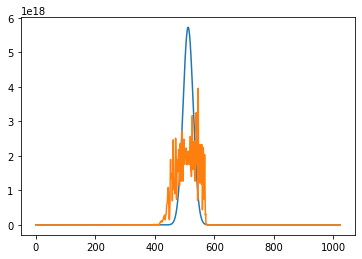

In [26]:
plt.plot(data_t[0,])
plt.plot(data_t[479,])
plt.show()

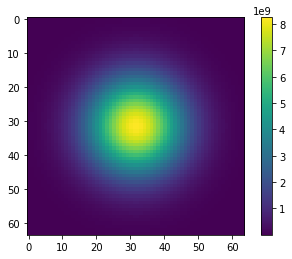

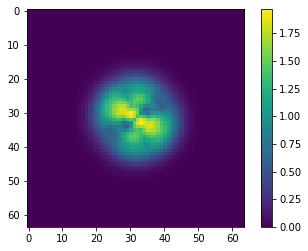

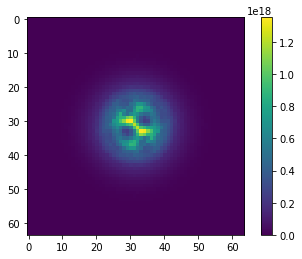

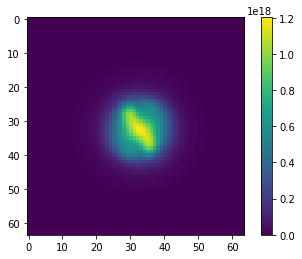

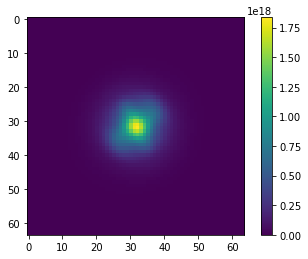

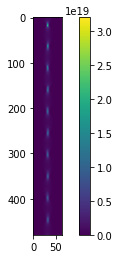

In [27]:
plt.imshow(np.abs(A_disp))
plt.colorbar()
plt.show()
plt.imshow(np.angle(A_disp))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[0,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[239,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[479,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[:,32,:]))
plt.colorbar()
plt.show()

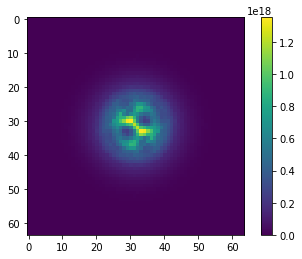

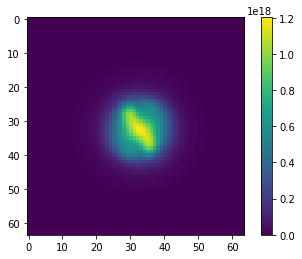

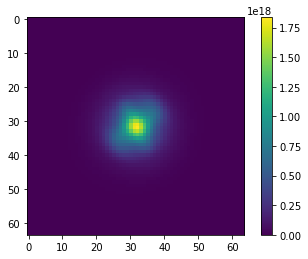

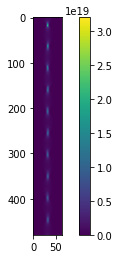

In [28]:
plt.imshow(np.squeeze(data_s[0,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[239,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[479,]))
plt.colorbar()
plt.show()

plt.imshow(np.squeeze(data_s[:,32,:]))
plt.colorbar()
plt.show()